# LSTM(Long Short Term Memory)
https://dgkim5360.tistory.com/entry/understanding-long-short-term-memory-lstm-kr

### 기울기 소실(Gradient Vanishing)과 기울기 폭발(Gradient Exploding)의 원인

dh:
 [[1. 1. 1.]
 [1. 1. 1.]]
Wh:
 [[ 1.78862847  0.43650985  0.09649747]
 [-1.8634927  -0.2773882  -0.35475898]
 [-0.08274148 -0.62700068 -0.04381817]]
[2.4684068094579303, 3.3357049741610365, 4.783279375373182, 6.279587332087612, 8.080776465019053, 10.251163032292936, 12.936063506609896, 16.276861327786712, 20.45482961834598, 25.688972842084684, 32.25315718048336, 40.48895641683869, 50.8244073070191, 63.79612654485427, 80.07737014308985, 100.5129892205125, 126.16331847536823, 158.35920648258823, 198.7710796761195, 249.495615421267]


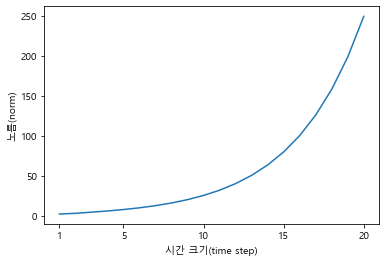

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rc('font', family='Malgun Gothic')

N = 2  # 미니배치 크기
H = 3  # 은닉 상태 벡터의 차원 수
T = 20 # 시계열 데이터의 길이

dh = np.ones((N,H))  # (2,3)
print('dh:\n',dh)

np.random.seed(3)   # 재현할 수 있도록 난수의 시드 고정

Wh = np.random.randn(H,H)         # 기울기 폭발 (스칼라일 경우 Wh가 1보다 큰 경우)   --> NaN, 발산
# Wh = np.random.randn(H,H)*0.5   # 기울기 소실 (스칼라일 경우 Wh가 1보다 작은 경우) --> 0 
print('Wh:\n',Wh)


# Norm은 벡터의 길이 혹은 크기를 측정하는 방법(함수)이다
# L1 norm : 벡터의 각 요소의 절대값을 모두 합한 값
# L2 norm : 각 요소의 제곱을 모두 합하여 제곱근을 취한 값
# http://taewan.kim/post/norm/
norm_list = []
for t in range(T):
    dh = np.dot(dh,Wh.T)   # 미분, gradient 값
    # print('-'*30)
    # print(dh)
    norm = np.sqrt(np.sum(dh**2))/N  # 평균 norm
    # print(norm)
    norm_list.append(norm)

print(norm_list)  

# 그래프 그리기
plt.plot(np.arange(len(norm_list)), norm_list)
plt.xticks([0, 4, 9, 14, 19], [1, 5, 10, 15, 20])
plt.xlabel('시간 크기(time step)')
plt.ylabel('노름(norm)')
plt.show()

### 기울기 폭발 대책 : 기울기 클리핑(gradient cliping) 함수 구현
https://wikidocs.net/61375

In [2]:

dW1 = np.random.rand(3,3)*10
dW2 = np.random.rand(3,3)*10
print('dW1:\n',dW1)
print('dW2:\n',dW2)

grads = [dW1,dW2]

max_norm = 5.0   # threshold, 한계값

## nn_layers.py 에 추가한다
def clip_grads(grads, max_norm):
    total_norm = 0
    for grad in grads:  # L2 norm 구하기 , 제곱의 합의 제곱근
        total_norm += np.sum(grad ** 2)
    total_norm = np.sqrt(total_norm)

    rate = max_norm / (total_norm + 1e-6)
    # print('rate:',rate)
    if rate < 1:     # total_norm 이 한계값(max_norm) 보다 클경우
        for grad in grads:
            grad *= rate
    

print('(dW1) before:', dW1.flatten())
#print('(dW2) before:', dW2.flatten())
clip_grads(grads, max_norm)
print('(dw1) after:', dW1.flatten())  # 값이 약간 줄어듦    
#print('(dw2) after:', dW2.flatten())  # 값이 약간 줄어듦    

dW1:
 [[6.49144048 2.78487283 6.76254902]
 [5.90862817 0.23981882 5.58854088]
 [2.59252447 4.15101197 2.83525082]]
dW2:
 [[6.93137918 4.40453718 1.56867738]
 [5.44649018 7.80314765 3.06363532]
 [2.21957884 3.87971258 9.3638365 ]]
(dW1) before: [6.49144048 2.78487283 6.76254902 5.90862817 0.23981882 5.58854088
 2.59252447 4.15101197 2.83525082]
(dw1) after: [1.49503731 0.64138134 1.55747605 1.36081038 0.05523244 1.28709139
 0.59708178 0.95601551 0.65298384]


### 기울기 소실 방지 : Gated RNN 인 LSTM(Long Short Term Memory)이나  GRU(Gated Recurrent Units ) 사용

### LSTM  : RNN에 기억 셀 𝐜<sub>𝐭</sub> 과 , f , g, i, o 게이트 4개를 추가

In [ ]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
# nn_layers.py 에 sigmoid 함수를 추가한다


class LSTM:
    def __init__(self,Wx,Wh,b):
        '''
        Parameters
        ----------
        Wx: 입력 x에 대한 가중치 매개변수(4개분의 가중치가 담겨 있음)
        Wh: 은닉 상태 h에 대한 가중치 매개변수(4개분의 가중치가 담겨 있음)
        b: 편향（4개분의 편향이 담겨 있음）
        '''
        self.params = [Wx,Wh,b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None
        
    def forward(self,x,h_prev,c_prev) :
        Wx, Wh, b = self.params           # Wx,Wh : (D,4*H)로 생성하여 입력됨
        N, H = h_prev.shape
        
        A = np.dot(x,Wx) + np.dot(h_prev,Wh) + b
        
        # 동일한 사이즈 4개로 슬라이싱 : f,g,i,o
        f = A[:, :H]
        g = A[:, H:2*H]
        i = A[:, 2*H:3*H]
        o = A[:, 3*H:]
        
        f = sigmoid(f)
        g = np.tanh(g)
        i = sigmoid(i)
        o = sigmoid(o)
        
        c_next = f*c_prev + g*i
        h_next = _______________
        
        
        
        
        
        
    